In [ ]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision
from statistics import mean
import numpy as np
import os
#path_data = 'MyDrive/Dati CNN/'
#path_mount = '/content/drive/'
#from google.colab import drive
#drive.mount('/content/drive')
#subject = 'encoder_nullo'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Encoder class

In [ ]:
input_dim = (28 * 28)
hidden_dim = 10
out_dim = 10

class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Encoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


    def forward(self, x):
        encoded = self.encoder(x)

        return encoded

pret_autoenc = Encoder(input_dim, out_dim).to(device)

Extraction of test set

In [ ]:
n_train = 8000
n_test = 350

batch_size_train = 16
batch_size_test = 32

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train = False, download = True, transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[n_train:(n_train + n_test)], dataset_test.targets[n_train:(n_train + n_test)]
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)

Summery of the encoder architeture

In [ ]:
from torchsummary import summary
summary(pret_autoenc, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             292
              ReLU-5            [-1, 4, 14, 14]               0
         MaxPool2d-6              [-1, 4, 7, 7]               0
Total params: 372
Trainable params: 372
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


The model gets saved

In [ ]:
# Save the model
torch.save(pret_autoenc.state_dict(), 'null_model.pth')

Initialization of the weights with different functions

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        m.bias.data.fill_(0.01)

#pret_autoenc = Encoder(input_dim, out_dim).to(device)
#pret_autoenc.apply(weights_init)

Encoder with Softmax class

In [ ]:
class EncoderWithSoftmax(nn.Module):
    def __init__(self, pretrained_autoencoder):
        super(EncoderWithSoftmax, self).__init__()

        # Extraction of the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder

        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add the softmax layer
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 4 * 7 * 7, out_features=10)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

Summery of the encoder + Softmax architeture

In [ ]:
temp = EncoderWithSoftmax(pret_autoenc)
summary(temp, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4            [-1, 4, 14, 14]             292
              ReLU-5            [-1, 4, 14, 14]               0
         MaxPool2d-6              [-1, 4, 7, 7]               0
           Encoder-7              [-1, 4, 7, 7]               0
           Flatten-8                  [-1, 196]               0
            Linear-9                   [-1, 10]           1,970
          Softmax-10                   [-1, 10]               0
Total params: 2,342
Trainable params: 1,970
Non-trainable params: 372
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.01
Estimated Tot

Functions to train the encoder + Softmax

In [ ]:
def accuracy(y_pred, y):

    pred = y_pred.detach().argmax(dim=1)
    corrects = (pred == y)
    accuracy = (corrects.sum()/corrects.size(0)).float()

    return accuracy


def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

    acc_train, acc_test = 0, 0
    running_loss = 0.0

    with torch.no_grad():

        for x_train, y_train in train_loader:

            x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

            out = model(x_train).squeeze()
            acc_train += accuracy(out, y_train)

        for x_test, y_test in test_loader:

            x_test, y_test = x_test.to(device), y_test.to(device)

            out = model(x_test).squeeze()
            loss = loss_function(out, y_test)
            running_loss += loss.item()
            acc_test += accuracy(out, y_test)

        val_loss = running_loss / len(test_loader)
        acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

    return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100, val_loss


def train(model, x, y, loss_function, optimizer):
    model.train()
    out = model(x).squeeze()

    loss = loss_function(out, y)

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

    optimizer.step()
    return float(loss)

Loss function

In [ ]:
loss_function = nn.CrossEntropyLoss()

Training of the Softmax for 100 epochs with 50 different dataset sizes

In [ ]:
old_acc = []
old_train = []
old_test = []

ratio = 50
EPOCHS = 100
n_runs = 3 #every training is repeated 3 times and avaraged

for j in range(n_runs):

    ACCURACY_matrix = []
    TrainLOSS_matrix = []
    TestLOSS_matrix = []

    print(f"Run Number: {j+1}")

    for i in range (1, ratio+1):

        train_losses = []
        test_losses = []
        test_accuracies = []

        # Set the datasetsize
        n_train_loop = int(n_train * i / ratio)
        #batch_size_train_loop = int(batch_size_train * i / ratio)

        # Create the train dataset and the train loader
        dataset_train =  torchvision.datasets.MNIST('./files/', train = False, download = True, transform = transform)
        dataset_train.data, dataset_train.targets = dataset_train.data[:n_train_loop], dataset_train.targets[:n_train_loop]
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle = True, drop_last = True)

        # Call our Net
        model = EncoderWithSoftmax(pret_autoenc).to(device)

        #Set the Optimazer
        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

        for epoch in range(1,EPOCHS+1):
            train_loss = 0

            for x_train, y_train in train_loader:
                x_train, y_train = x_train.to(device), y_train.to(device)
                loss = train(model, x_train, y_train, loss_function, optimizer)
                train_loss += loss

            train_loss /= len(train_loader)                    # we divide by the number of batches
            train_losses.append(train_loss)

            train_acc, test_acc, test_loss = evaluate(model, train_loader, test_loader)
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)

            if epoch % 25 == 0:
                print("Epoch:", epoch, "Loss:", float(train_loss), "Test Loss:", test_loss, "data:", len(dataset_train.data), "train_acc", train_acc, "test_acc", test_acc)

        # Save in ACCURACY_matrix
        ACCURACY_matrix.append(test_accuracies)
        TrainLOSS_matrix.append(train_losses)
        TestLOSS_matrix.append(test_losses)

    if j == 0:

        old_acc = ACCURACY_matrix
        old_train = TrainLOSS_matrix
        old_test = TestLOSS_matrix

    else:

        # For old_acc and ACCURACY_matrix
        old_acc = [[old_acc[row][col] + ACCURACY_matrix[row][col] for col in range(len(old_acc[0]))] for row in range(len(old_acc))]

        # For old_train and TrainLOSS_matrix
        old_train = [[old_train[row][col] + TrainLOSS_matrix[row][col] for col in range(len(old_train[0]))] for row in range(len(old_train))]

        # For old_test and TestLOSS_matrix
        old_test = [[old_test[row][col] + TestLOSS_matrix[row][col] for col in range(len(old_test[0]))] for row in range(len(old_test))]


    print("\n")

Run Number: 1
Epoch: 25 Loss: 2.1718710899353026 Test Loss: 2.2411774505268443 data: 160 train_acc 43.75 test_acc 35.41666567325592
Epoch: 50 Loss: 2.0565442085266112 Test Loss: 2.1667079708792945 data: 160 train_acc 53.75000238418579 test_acc 40.56818187236786
Epoch: 75 Loss: 1.9582252740859984 Test Loss: 2.109891241247004 data: 160 train_acc 73.7500011920929 test_acc 49.48863685131073
Epoch: 100 Loss: 1.877472198009491 Test Loss: 2.063284310427579 data: 160 train_acc 78.125 test_acc 54.905301332473755
Epoch: 25 Loss: 2.085508632659912 Test Loss: 2.181081078269265 data: 320 train_acc 50.93749761581421 test_acc 39.393940567970276
Epoch: 50 Loss: 1.9265948832035065 Test Loss: 2.08096304806796 data: 320 train_acc 73.1249988079071 test_acc 53.44696640968323
Epoch: 75 Loss: 1.8270367443561555 Test Loss: 2.0176593498750166 data: 320 train_acc 81.25 test_acc 59.185606241226196
Epoch: 100 Loss: 1.7715290486812592 Test Loss: 1.980462995442477 data: 320 train_acc 81.87500238418579 test_acc 61.4

Epoch: 25 Loss: 1.7373007010011112 Test Loss: 1.8582835089076648 data: 2720 train_acc 83.60294103622437 test_acc 71.7424213886261
Epoch: 50 Loss: 1.6579377539017621 Test Loss: 1.7690001834522595 data: 2720 train_acc 87.3161792755127 test_acc 77.9924213886261
Epoch: 75 Loss: 1.6237244620042688 Test Loss: 1.716358639977195 data: 2720 train_acc 89.41176533699036 test_acc 81.40151500701904
Epoch: 100 Loss: 1.603207076297087 Test Loss: 1.6797193939035588 data: 2720 train_acc 90.66176414489746 test_acc 83.97727608680725
Epoch: 25 Loss: 1.7296145644452836 Test Loss: 1.8475853638215498 data: 2880 train_acc 83.57638716697693 test_acc 72.85985350608826
Epoch: 50 Loss: 1.6533893333541023 Test Loss: 1.7550271966240623 data: 2880 train_acc 87.29166388511658 test_acc 78.56060266494751
Epoch: 75 Loss: 1.619826187690099 Test Loss: 1.7017971060492776 data: 2880 train_acc 89.23611044883728 test_acc 83.40909481048584
Epoch: 100 Loss: 1.600403579738405 Test Loss: 1.6735741658644243 data: 2880 train_acc 90

Epoch: 100 Loss: 1.577782379090786 Test Loss: 1.6161157217892734 data: 5120 train_acc 91.5820300579071 test_acc 89.71590399742126
Epoch: 25 Loss: 1.6660359209234064 Test Loss: 1.7355927228927612 data: 5280 train_acc 86.55303120613098 test_acc 81.72348141670227
Epoch: 50 Loss: 1.6125087163665077 Test Loss: 1.6562686399980024 data: 5280 train_acc 89.73484635353088 test_acc 86.85606122016907
Epoch: 75 Loss: 1.5898411324529937 Test Loss: 1.6242078976197676 data: 5280 train_acc 90.9469723701477 test_acc 89.4318163394928
Epoch: 100 Loss: 1.5764215447685934 Test Loss: 1.6066909594969316 data: 5280 train_acc 91.79924130439758 test_acc 90.28408527374268
Epoch: 25 Loss: 1.660097214053659 Test Loss: 1.7261801416223699 data: 5440 train_acc 87.07720637321472 test_acc 82.57575631141663
Epoch: 50 Loss: 1.6080096335972056 Test Loss: 1.6500362699682063 data: 5440 train_acc 89.90808725357056 test_acc 86.85606122016907
Epoch: 75 Loss: 1.5859100990435657 Test Loss: 1.6191745454614812 data: 5440 train_acc 

Epoch: 75 Loss: 1.5667328270773093 Test Loss: 1.5735877752304077 data: 7680 train_acc 92.36978888511658 test_acc 93.12499761581421
Epoch: 100 Loss: 1.5564423196017743 Test Loss: 1.5622510801662097 data: 7680 train_acc 92.91666746139526 test_acc 93.69317889213562
Epoch: 25 Loss: 1.6259492998220482 Test Loss: 1.6386905908584595 data: 7840 train_acc 89.34949040412903 test_acc 89.98106122016907
Epoch: 50 Loss: 1.5832009918835699 Test Loss: 1.5906519998203625 data: 7840 train_acc 91.54336452484131 test_acc 91.98863506317139
Epoch: 75 Loss: 1.565750550250618 Test Loss: 1.570927782492204 data: 7840 train_acc 92.5000011920929 test_acc 92.84090399742126
Epoch: 100 Loss: 1.5558260961454742 Test Loss: 1.5619965466586025 data: 7840 train_acc 93.20152997970581 test_acc 93.40908527374268
Epoch: 25 Loss: 1.6249277410507201 Test Loss: 1.6310894706032493 data: 8000 train_acc 89.28750157356262 test_acc 90.28408527374268
Epoch: 50 Loss: 1.5825968754291535 Test Loss: 1.5825209400870583 data: 8000 train_ac

Epoch: 75 Loss: 1.6370507316929954 Test Loss: 1.7308631160042502 data: 2240 train_acc 88.43749761581421 test_acc 80.26514649391174
Epoch: 100 Loss: 1.6129965535231998 Test Loss: 1.6933582696047695 data: 2240 train_acc 90.04464149475098 test_acc 84.26136374473572
Epoch: 25 Loss: 1.7524531920750936 Test Loss: 1.8705486926165493 data: 2400 train_acc 83.45833420753479 test_acc 71.45833373069763
Epoch: 50 Loss: 1.6686837299664816 Test Loss: 1.7793611288070679 data: 2400 train_acc 87.12499737739563 test_acc 77.14014649391174
Epoch: 75 Loss: 1.6313815498352051 Test Loss: 1.718146031553095 data: 2400 train_acc 88.7083351612091 test_acc 82.53787755966187
Epoch: 100 Loss: 1.6088829890886942 Test Loss: 1.685104164210233 data: 2400 train_acc 90.37500023841858 test_acc 83.6931824684143
Epoch: 25 Loss: 1.7442172221839427 Test Loss: 1.8615574511614712 data: 2560 train_acc 83.16406011581421 test_acc 73.16287755966187
Epoch: 50 Loss: 1.6624903932213784 Test Loss: 1.7711142084815286 data: 2560 train_acc

Epoch: 50 Loss: 1.618654420375824 Test Loss: 1.6842220588163896 data: 4800 train_acc 89.12500143051147 test_acc 84.01515483856201
Epoch: 75 Loss: 1.5943442821502685 Test Loss: 1.6496330499649048 data: 4800 train_acc 90.66666960716248 test_acc 86.3068163394928
Epoch: 100 Loss: 1.57995752175649 Test Loss: 1.6310395002365112 data: 4800 train_acc 91.56249761581421 test_acc 88.27651739120483
Epoch: 25 Loss: 1.6717004279936514 Test Loss: 1.7785609635439785 data: 4960 train_acc 86.16935610771179 test_acc 77.14014649391174
Epoch: 50 Loss: 1.6166571290262284 Test Loss: 1.683043588291515 data: 4960 train_acc 89.21371102333069 test_acc 83.97727608680725
Epoch: 75 Loss: 1.5929912017237755 Test Loss: 1.6465251445770264 data: 4960 train_acc 90.66532254219055 test_acc 87.14015483856201
Epoch: 100 Loss: 1.5788878721575583 Test Loss: 1.6275315284729004 data: 4960 train_acc 91.55241847038269 test_acc 88.57954144477844
Epoch: 25 Loss: 1.6691350989043712 Test Loss: 1.7523599646308206 data: 5120 train_acc 

Epoch: 25 Loss: 1.6297858994940053 Test Loss: 1.6532121029767124 data: 7360 train_acc 89.04891014099121 test_acc 87.97348141670227
Epoch: 50 Loss: 1.5862153584542482 Test Loss: 1.6014156558296897 data: 7360 train_acc 91.3179337978363 test_acc 91.70454144477844
Epoch: 75 Loss: 1.5681285104025966 Test Loss: 1.5816937576640735 data: 7360 train_acc 92.30978488922119 test_acc 92.5568163394928
Epoch: 100 Loss: 1.5578942697981129 Test Loss: 1.568633870645003 data: 7360 train_acc 92.9619550704956 test_acc 93.12499761581421
Epoch: 25 Loss: 1.6294944392873887 Test Loss: 1.6479706330732866 data: 7520 train_acc 89.1090452671051 test_acc 88.84469866752625
Epoch: 50 Loss: 1.5858132823984674 Test Loss: 1.5941073135896162 data: 7520 train_acc 91.31649136543274 test_acc 91.98863506317139
Epoch: 75 Loss: 1.5679490160434804 Test Loss: 1.5741856640035456 data: 7520 train_acc 92.42021441459656 test_acc 92.84090399742126
Epoch: 100 Loss: 1.5576488842355445 Test Loss: 1.5638685118068347 data: 7520 train_acc 

Epoch: 25 Loss: 1.7835687110821405 Test Loss: 1.9023797078566118 data: 1920 train_acc 81.5625011920929 test_acc 68.8825786113739
Epoch: 50 Loss: 1.6882022221883137 Test Loss: 1.8141415877775713 data: 1920 train_acc 86.19791865348816 test_acc 72.87878394126892
Epoch: 75 Loss: 1.6461138308048249 Test Loss: 1.7611144889484753 data: 1920 train_acc 88.54166865348816 test_acc 78.56060266494751
Epoch: 100 Loss: 1.620461172858874 Test Loss: 1.7231346693905918 data: 1920 train_acc 89.73958492279053 test_acc 79.98105883598328
Epoch: 25 Loss: 1.7712921720284682 Test Loss: 1.891344352201982 data: 2080 train_acc 82.11538195610046 test_acc 68.31439733505249
Epoch: 50 Loss: 1.681458352162288 Test Loss: 1.8041160865263506 data: 2080 train_acc 86.2500011920929 test_acc 74.29924011230469
Epoch: 75 Loss: 1.6410661532328679 Test Loss: 1.752125696702437 data: 2080 train_acc 88.60576748847961 test_acc 78.29545736312866
Epoch: 100 Loss: 1.6164884796509376 Test Loss: 1.7105807716196233 data: 2080 train_acc 89

Epoch: 100 Loss: 1.5835553314950732 Test Loss: 1.6383303187110207 data: 4320 train_acc 91.38888716697693 test_acc 87.70833611488342
Epoch: 25 Loss: 1.6814047349350794 Test Loss: 1.7911531925201416 data: 4480 train_acc 85.60267686843872 test_acc 76.85605883598328
Epoch: 50 Loss: 1.6224766812154225 Test Loss: 1.6933464787223123 data: 4480 train_acc 88.79464268684387 test_acc 83.1250011920929
Epoch: 75 Loss: 1.597441303730011 Test Loss: 1.6567956100810657 data: 4480 train_acc 90.22321701049805 test_acc 85.71969866752625
Epoch: 100 Loss: 1.5828018235308783 Test Loss: 1.6335440548983486 data: 4480 train_acc 91.36160612106323 test_acc 87.99242377281189
Epoch: 25 Loss: 1.678321751232805 Test Loss: 1.7859129472212358 data: 4640 train_acc 85.6249988079071 test_acc 76.85605883598328
Epoch: 50 Loss: 1.620949754221686 Test Loss: 1.689820181239735 data: 4640 train_acc 88.98707032203674 test_acc 83.40909481048584
Epoch: 75 Loss: 1.5964390376518514 Test Loss: 1.6510705514387651 data: 4640 train_acc 9

Epoch: 75 Loss: 1.5722250054048938 Test Loss: 1.5879893844777888 data: 6880 train_acc 92.00581312179565 test_acc 91.98863506317139
Epoch: 100 Loss: 1.5611560120139012 Test Loss: 1.5762036063454368 data: 6880 train_acc 92.9215133190155 test_acc 91.98863506317139
Epoch: 25 Loss: 1.6346548803827978 Test Loss: 1.6684345115314831 data: 7040 train_acc 88.90625238418579 test_acc 87.99242377281189
Epoch: 50 Loss: 1.5896331228993155 Test Loss: 1.6091459447687322 data: 7040 train_acc 91.27840995788574 test_acc 90.56817889213562
Epoch: 75 Loss: 1.5709196789698168 Test Loss: 1.5849305391311646 data: 7040 train_acc 92.20170378684998 test_acc 92.84090399742126
Epoch: 100 Loss: 1.5601704841310329 Test Loss: 1.5729315064170144 data: 7040 train_acc 92.88352131843567 test_acc 93.12499761581421
Epoch: 25 Loss: 1.6318162224027846 Test Loss: 1.6618005145679822 data: 7200 train_acc 88.99999856948853 test_acc 87.70833611488342
Epoch: 50 Loss: 1.5877757332060072 Test Loss: 1.6052371263504028 data: 7200 train_

Avarage of the three runs

In [ ]:
ACCURACY_matrix = [[element / n_runs for element in row] for row in old_acc]
TrainLOSS_matrix = [[element / n_runs for element in row] for row in old_train]
TestLOSS_matrix = [[element / n_runs for element in row] for row in old_test]

Accuracy of encoder with Softmax over the dataset sizes

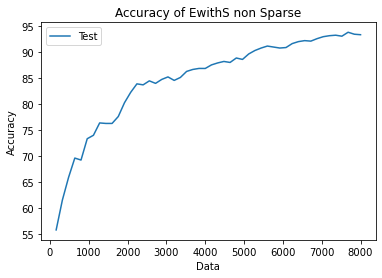

In [ ]:
# Extract last non-zero values from each list
last_elements = [sublist[-1] for sublist in ACCURACY_matrix]


# The size of the dataset
data = [n_train * i/ratio for i in range(1, ratio + 1)]

# Plot the values
plt.plot(data, last_elements, label = "Test")
plt.xlabel("Data")
plt.ylabel("Accuracy")
plt.title('Accuracy of EwithS')
plt.legend()
plt.show()

Loss in function of the epochs for all the dataset sizes

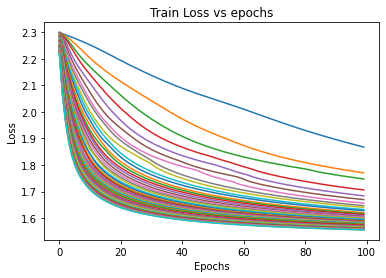

In [ ]:
# Extract last non-zero values from each list
for i in range(len(TrainLOSS_matrix)):
    plt.plot(range(EPOCHS), TrainLOSS_matrix[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs epochs')
plt.show()

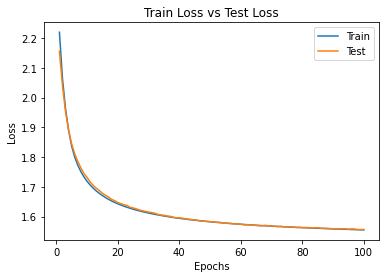

In [ ]:
plt.plot(range(1, EPOCHS + 1), TrainLOSS_matrix[-1], label = "Train")
plt.plot(range(1, EPOCHS + 1), TestLOSS_matrix[-1], label = "Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Train Loss vs Test Loss')
plt.legend()
plt.show()

Example of confusion matrix for the last run

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.eval()

all_y = []
all_predictions = []

# Iterate over the dataset
for x, y in test_loader:
    x = x.to(device)

    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)

    all_y.extend(y.numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_y = np.array(all_y)
all_predictions = np.array(all_predictions)

conf_matrix = confusion_matrix(all_y, all_predictions, normalize = "true")

print(conf_matrix.round(decimals=2))

[[0.97 0.   0.   0.   0.   0.   0.03 0.   0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.   0.   0.03 0.  ]
 [0.   0.   0.78 0.03 0.08 0.   0.03 0.03 0.03 0.03]
 [0.   0.   0.   0.97 0.   0.   0.03 0.   0.   0.  ]
 [0.   0.   0.   0.   0.97 0.   0.   0.   0.   0.03]
 [0.   0.   0.   0.04 0.04 0.89 0.   0.   0.04 0.  ]
 [0.   0.   0.   0.06 0.   0.03 0.92 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.03 0.   0.03 0.03 0.   0.91 0.  ]
 [0.03 0.   0.   0.   0.   0.03 0.   0.03 0.   0.91]]


Text(0.5, -14.597979746446661, 'Predicted label')

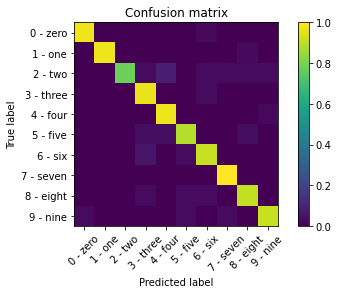

In [ ]:
classes = dataset_test.classes

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix)
plt.title("Confusion matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Saving the results in files

In [ ]:
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

file_name1 = 'TrainLOSS_matrix_MNIST_normal_NA.npy'
np.save(os.path.join(result_dir, file_name1), TrainLOSS_matrix)

file_name2 = 'ACCURACY_matrix_MNIST_normal_NA.npy'
np.save(os.path.join(result_dir, file_name2), ACCURACY_matrix)

file_name3 = 'TestLOSS_matrix_MNIST_normal_NA.npy'
np.save(os.path.join(result_dir, file_name3), TestLOSS_matrix)